In [1]:
from projectFunctions import formatDataset
import os
import time

# Define file paths to training/testing set data
trainDataset = './ExampleSets/INRIAFullDataset/INRIAFullTrain.tar.gz'
testDataset = './ExampleSets/INRIAFullDataset/INRIAFullTest.tar.gz'

# Make folder to save graphs to if it doesn't exist already
graphFolder = './AblationImages'
if not os.path.isdir(graphFolder): os.mkdir(graphFolder)

print('Calculating HOG features...')
modelStartTime = time.time()
_, modelTrainFeatures, modelTrainLabels = formatDataset(
    trainDataset, 
    blockDimensions = (3, 3), 
    deleteDir = True, 
    randomSeed = 48
)
_, modelTestFeatures, modelTestLabels = formatDataset(
    testDataset, 
    blockDimensions = (3, 3), 
    deleteDir = True, 
    randomSeed = 48
)
print((
    'HOG features calculated; elapsed time = '
    f'{time.time() - modelStartTime:.2f} seconds'
))

Calculating HOG features...
HOG features calculated; elapsed time = 14.74 seconds


In [2]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Create and train SVM classifier
modelSVM = LinearSVC(random_state = 48)
modelSVM.fit(modelTrainFeatures, modelTrainLabels)

# Get predictions and decision function on the testing set
modelPredicts = modelSVM.predict(modelTestFeatures)
modelDecisions = modelSVM.decision_function(modelTestFeatures)

# Use iterator to calculate performance metrics with predictions
modelAccuracy = accuracy_score(modelTestLabels, modelPredicts)
modelPrecision = precision_score(modelTestLabels, modelPredicts)
modelRecall = recall_score(modelTestLabels, modelPredicts)
modelF1 = f1_score(modelTestLabels, modelPredicts)
modelAUC = roc_auc_score(modelTestLabels, modelDecisions)

# Compile performance metrics into Series
modelScores = pd.Series(
    (modelAccuracy, modelPrecision, modelRecall, modelF1, modelAUC), 
    index = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
)

# Display DataFrame with caption
print('Performance Scores of HOG Features on INRIA Testing Dataset')
modelScores

Performance Scores of HOG Features on INRIA Testing Dataset


Accuracy     0.963333
Precision    0.960265
Recall       0.966667
F1 Score     0.963455
AUC          0.994593
dtype: float64

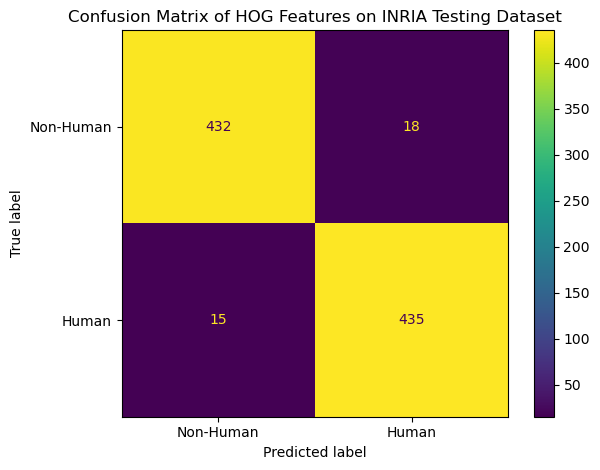

In [5]:
# Import confusion matrix and matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix for default parameter model
ConfusionMatrixDisplay.from_predictions(
    modelTestLabels, modelPredicts, display_labels = ['Non-Human', 'Human']
)

plt.title('Confusion Matrix of HOG Features on INRIA Testing Dataset')
plt.tight_layout()
plt.savefig(os.path.join(graphFolder, 'final_matrix.png'))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

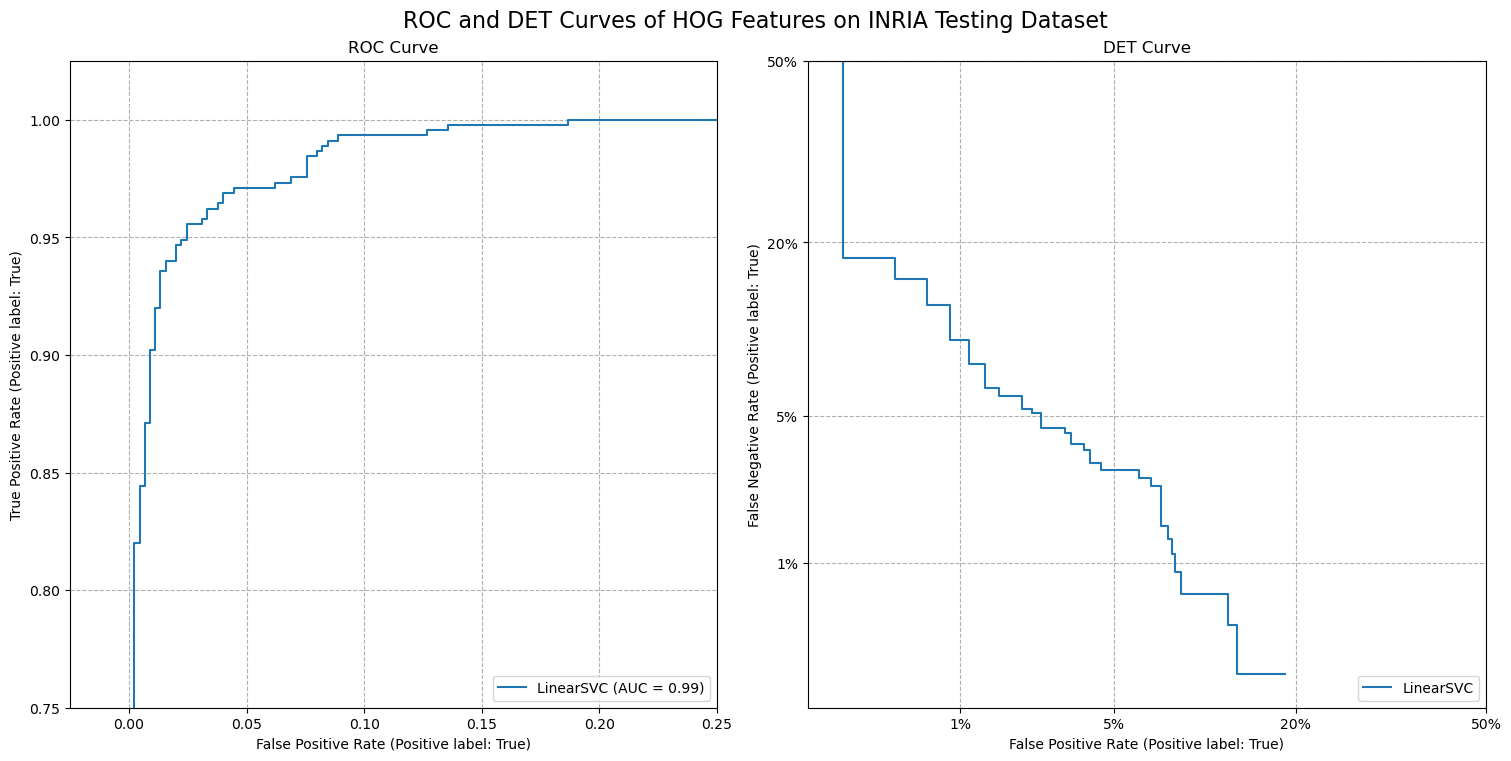

In [4]:
# Import ROC and DET curve functions
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Initialise curve figure
curveFigure, (rocAxes, detAxes) = plt.subplots(
    1, 2, figsize = (15,7.5), constrained_layout = True
)

# Generate ROC and DET curves for each normalisation technique
RocCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=rocAxes
)
DetCurveDisplay.from_estimator(
    modelSVM, modelTestFeatures, modelTestLabels, ax=detAxes
)
rocAxes.grid(linestyle = "--") 
detAxes.grid(linestyle = "--") 

    
"""
    # Modify legend to avoid curve and label L2-Hys matrix as default
    labels = axis.get_legend_handles_labels()[1]
    labels[-1] = labels[-1].replace(
        'Normalisation', 'Normalisation (Default)'
    )
    axis.legend(
        labels = labels, 
        loc = 'upper right' if fn is DetCurveDisplay else 'lower right'
    )
"""

# Add titles and adjust limits for each axis
rocAxes.set_title('ROC Curve')
rocAxes.set_xlim([-0.025, 0.25])
rocAxes.set_ylim([0.75, 1.025])

detAxes.set_title('DET Curve')
detAxes.set_xlim([-3, 0])
detAxes.set_ylim([-3, 0])

# Set figure title
curveFigure.suptitle(
    'ROC and DET Curves of HOG Features on INRIA Testing Dataset', fontsize = 16
)

# Save curves as image
plt.savefig(os.path.join(graphFolder, 'final_curves.png'))

# Display ROC and DET curves
plt.show